# Getting started

This tutorial shows you how to get started with the `povm_toolbox`.

In [1]:
%load_ext autoreload
%autoreload 2

## Compute circuit output probabilities with `POVMSampler`
Follow these instructions to get the probability distribution of a quantum circuit with the `povm_toolbox.sampler.POVMSampler` sampler.

### Initialize QuantumCircuit
The first step is to create the `qiskit.circuit.QuantumCircuits` from which you want to obtain the probability distribution.

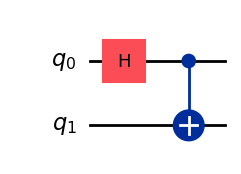

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl", style="iqp")

> **Note**: 
>
> The `qiskit.circuit.QuantumCircuit` you pass to `povm_toolbox.sampler.POVMSampler` must not include measurements. These will later be specified by the chosen POVM.

### Initialize `Sampler` and `POVMSampler`
Next, create a `povm_toolbox.sampler.POVMSampler` instance, which will internally use a `qiskit.primitives.Sampler` instance.

In [3]:
from numpy.random import default_rng
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler as Sampler

rng = default_rng(22)

sampler = Sampler(seed=rng)
povm_sampler = POVMSampler(sampler=sampler)

### Initialize measurement procedure
Next, create a `povm_toolbox.library.POVMImplementation` instance.

In [4]:
from povm_toolbox.library import ClassicalShadows

measurement = ClassicalShadows(num_qubits=2, seed=12)

### Run and get results
Now that you have defined your `povm_sampler`, run it by calling the `povm_toolbox.sampler.POVMSampler.run` method, which returns an instance of `povm_toolbox.sampler.POVMSamplerJob`. You can get the results from the job (as a `qiskit.primitives.PrimitiveResult` object) with the `povm_toolbox.sampler.POVMSamplerJob.result` method.

In [5]:
job = povm_sampler.run([qc], shots=256, povm=measurement)
result = job.result()
print(result)

PrimitiveResult([POVMPubResult(data=DataBin(povm_measurement_creg=BitArray(<shape=(), num_shots=256, num_bits=2>)), metadata=RPMMetadata(povm_implementation=ClassicalShadows(num_qubits=2), composed_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001E6C4698F10>, pvm_keys=np.ndarray<256,2>))], metadata={'raw_results': PrimitiveResult([SamplerPubResult(data=DataBin(povm_measurement_creg=BitArray(<shape=(256,), num_shots=1, num_bits=2>), shape=(256,)), metadata={'shots': 1})], metadata={})})


While this example only uses one `qiskit.circuit.QuantumCircuit`, you can sample multiple circuits by passing a list of `povm_toolbox.sampler.POVMSamplerPubLike` objects to the `povm_toolbox.sampler.POVMSampler.run` method.

For each supplied `POVMSamplerPub`, the resulting `PrimitiveResult` object stores a corresponding `povm_toolbox.sampler.POVMPubResult` object.

### Get the outcome counts

From these results you can extract the outcome counts with the method `povm_toolbox.sampler.POVMPubResult.get_counts`.

In [6]:
pub_result = result[0]
counts = pub_result.get_counts()
print(counts, type(counts))

[Counter({(0, 0): 20, (4, 5): 18, (4, 0): 14, (5, 4): 13, (1, 1): 13, (4, 3): 12, (1, 5): 11, (2, 2): 10, (4, 2): 10, (0, 5): 9, (1, 4): 9, (3, 3): 8, (0, 2): 8, (1, 2): 7, (0, 4): 7, (2, 4): 7, (5, 0): 7, (4, 1): 7, (5, 2): 7, (2, 0): 7, (1, 3): 6, (0, 3): 6, (2, 1): 6, (5, 1): 6, (2, 5): 6, (5, 3): 5, (3, 5): 5, (3, 1): 5, (3, 0): 4, (3, 4): 3})] <class 'numpy.ndarray'>


Instead of counts, you can also query the individual samples of the POVM measurement outcomes with the method `povm_toolbox.sampler.POVMPubResult.get_samples`.

In [7]:
samples = pub_result.get_samples()
print(samples[:5], type(samples))  # the first 5 samples

[(1, 2), (5, 4), (0, 4), (1, 1), (3, 0)] <class 'list'>


## Compute an expectation value with the `POVMPostProcessor`

After having sampled some POVM outcomes, follow these instructions to get the expected value of an observable for a given quantum circuit with the `povm_toolbox.post_processor.POVMPostProcessor`.


### Initialize observables
The first step is to define the observables whose expected value you want to compute. Each observable can be any `BaseOperator`, like the operators from `qiskit.quantum_info`. Among them it is preferable to use `qiskit.quantum_info.SparsePauliOp`.

In [8]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

### Initialize the `POVMPostProcessor`

A `POVMPostProcessor` is initialized with an instance of a `POVMPubResult`.

In [9]:
from povm_toolbox.post_processor import POVMPostProcessor

post_processor = POVMPostProcessor(pub_result)

### Get the expected value

One can request the expectation value of an observable with the method `povm_toolbox.post_processor.POVMPostProcessor.get_expectation_value`.

In [10]:
exp_value, std = post_processor.get_expectation_value(observable)
print(exp_value)

3.8828125


For reference, we can compare our estimated expectation value to the exact value.

The post-processor can also compute the (estimated) standard deviation of the estimator we built.


In [11]:
import numpy as np
from qiskit.quantum_info import Statevector

exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
print(f"Exact value:     {exact_expectation_value}")

exp_value, std = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Exact value:     3.999999999999999
Estimated value: 3.8828125

Estimated standard deviation of the estimator: 0.26297472173936615
